In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import lars_optimizer as lars
import pandas as pd

## Function to preprocess images for finetuning
same as in Finetune/data_util_fine.py

In [2]:
def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(
          tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
          tf.cast(p, tf.float32)), lambda: func(x), lambda: x)

def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope or 'distorted_bounding_box_crop'):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image

def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.

  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.

  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize([image], [height, width],
                         method=tf.image.ResizeMethod.BICUBIC)[0]

def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.

  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)

def preprocess_for_train(image,
                         height,
                         width):
  """Preprocesses the given image for training.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
  Returns:
    A preprocessed image `Tensor`.
  """
  image = random_crop_with_resize(image, height, width)
  image = tf.image.random_flip_left_right(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

def preprocess_image(image, height, width):
  """Preprocesses the given image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  return preprocess_for_train(image, height, width)

In [3]:
dataset = 'cats_vs_dogs'
batch_size = 512
#only first 100% of dogs-cats images for finetuning
tfds_dogs_100pct_ds, info = tfds.load(dataset, split='train[:100%]', with_info=True)
num_images = info.splits['train[:100%]'].num_examples
num_classes = info.features['label'].num_classes
print('There are {} images in 100% dogs_vs_cats dataset. Obviously are {} classes'.format(num_images,num_classes))

There are 23262 images in 100% dogs_vs_cats dataset. Obviously are 2 classes


In [4]:
def _preprocess(x):
    x['image'] = preprocess_image(x['image'], 100, 100)
    return x
ds_100pct = tfds_dogs_100pct_ds.map(_preprocess).batch(batch_size)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


## Create/Load Model

In [5]:
learning_rate = 0.1

class Model(tf.keras.Model):
    def __init__(self, path):
        super(Model, self).__init__()
        self.saved_model = tf.saved_model.load(path)
        self.dense_layer = tf.keras.layers.Dense(units=num_classes, name='head_supervised_new')
        self.optimizer = lars.LARSOptimizer(learning_rate, momentum=0.9, weight_decay=0.,
                        exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
        
    def call(self, x):
        with tf.GradientTape() as tape:
            outputs = self.saved_model(x['image'], trainable=False)
            print(10*'#' + 'outputs' + 10*'#')
            print(outputs)
            print(26*'#')
            logits_t = self.dense_layer(outputs['final_avg_pool'])
            loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels = tf.one_hot(x['label'], num_classes), logits=logits_t))
            dense_layer_weights = self.dense_layer.trainable_weights
            print(10*'#' + 'Trainable variables' + 10*'#')
            print(dense_layer_weights)
            print(26*'#')
            grads = tape.gradient(loss_t, dense_layer_weights)
            self.optimizer.apply_gradients(zip(grads, dense_layer_weights))
            return loss_t, x['image'], logits_t, x['label']

In [6]:
#path to model
model_path = 'resnet50_pretrain100epochs_ImageNet/saved_model/'
#get_model 
model = Model(model_path)

In [7]:
##function to train a step
@tf.function
def train_step(x):
    return model(x)

In [8]:
counter_foo = 0
hist_loss, hist_acc, epochs = [], [], []
for epoch in range(50):
    for x in ds_100pct:
        counter_foo += 1
        loss, image, logits, labels = train_step(x)
        logits = logits.numpy()
        labels = labels.numpy()
        pred = logits.argmax(-1)
        correct = np.sum(pred == labels)
        total = labels.size
        hist_loss.append(loss.numpy())
        hist_acc.append(correct/float(total))
        epochs.append(counter_foo)
        print("[Iter {}] Loss: {} Top 1: {}".format(counter_foo, loss, correct/float(total)))

##########outputs##########
{'block_group4': <tf.Tensor 'model/StatefulPartitionedCall:3' shape=(512, 4, 4, 2048) dtype=float32>, 'final_avg_pool': <tf.Tensor 'model/StatefulPartitionedCall:4' shape=(512, 2048) dtype=float32>, 'block_group3': <tf.Tensor 'model/StatefulPartitionedCall:2' shape=(512, 7, 7, 1024) dtype=float32>, 'block_group2': <tf.Tensor 'model/StatefulPartitionedCall:1' shape=(512, 13, 13, 512) dtype=float32>, 'initial_max_pool': <tf.Tensor 'model/StatefulPartitionedCall:6' shape=(512, 25, 25, 64) dtype=float32>, 'logits_sup': <tf.Tensor 'model/StatefulPartitionedCall:7' shape=(512, 1000) dtype=float32>, 'initial_conv': <tf.Tensor 'model/StatefulPartitionedCall:5' shape=(512, 50, 50, 64) dtype=float32>, 'block_group1': <tf.Tensor 'model/StatefulPartitionedCall:0' shape=(512, 25, 25, 256) dtype=float32>}
##########################
##########Trainable variables##########
[<tf.Variable 'model/head_supervised_new/kernel:0' shape=(2048, 2) dtype=float32>, <tf.Variable 'model

[Iter 93] Loss: 0.12006696313619614 Top 1: 0.947265625
[Iter 94] Loss: 0.11773878335952759 Top 1: 0.947265625
[Iter 95] Loss: 0.13778698444366455 Top 1: 0.9609375
[Iter 96] Loss: 0.07973041385412216 Top 1: 0.96875
[Iter 97] Loss: 0.10566066205501556 Top 1: 0.951171875
[Iter 98] Loss: 0.10946366935968399 Top 1: 0.9609375
[Iter 99] Loss: 0.10023462772369385 Top 1: 0.966796875
[Iter 100] Loss: 0.100806824862957 Top 1: 0.96484375
[Iter 101] Loss: 0.13443201780319214 Top 1: 0.943359375
[Iter 102] Loss: 0.0951894149184227 Top 1: 0.955078125
[Iter 103] Loss: 0.10338379442691803 Top 1: 0.958984375
[Iter 104] Loss: 0.12606403231620789 Top 1: 0.951171875
[Iter 105] Loss: 0.14410154521465302 Top 1: 0.9453125
[Iter 106] Loss: 0.10204076766967773 Top 1: 0.951171875
[Iter 107] Loss: 0.08951917290687561 Top 1: 0.9609375
[Iter 108] Loss: 0.09650831669569016 Top 1: 0.95703125
[Iter 109] Loss: 0.11596802622079849 Top 1: 0.94921875
[Iter 110] Loss: 0.1456833779811859 Top 1: 0.931640625
[Iter 111] Loss: 0

[Iter 243] Loss: 0.11643378436565399 Top 1: 0.951171875
[Iter 244] Loss: 0.1346859633922577 Top 1: 0.953125
[Iter 245] Loss: 0.1128607839345932 Top 1: 0.947265625
[Iter 246] Loss: 0.08530660718679428 Top 1: 0.9609375
[Iter 247] Loss: 0.11695918440818787 Top 1: 0.947265625
[Iter 248] Loss: 0.08453996479511261 Top 1: 0.970703125
[Iter 249] Loss: 0.11037479341030121 Top 1: 0.958984375
[Iter 250] Loss: 0.08457525819540024 Top 1: 0.96875
[Iter 251] Loss: 0.1361270397901535 Top 1: 0.939453125
[Iter 252] Loss: 0.0847797840833664 Top 1: 0.962890625
[Iter 253] Loss: 0.1076534241437912 Top 1: 0.958984375
[Iter 254] Loss: 0.09424535930156708 Top 1: 0.958984375
[Iter 255] Loss: 0.11458352953195572 Top 1: 0.955078125
[Iter 256] Loss: 0.09749627113342285 Top 1: 0.962890625
[Iter 257] Loss: 0.13247732818126678 Top 1: 0.943359375
[Iter 258] Loss: 0.0950506404042244 Top 1: 0.966796875
[Iter 259] Loss: 0.10297506302595139 Top 1: 0.95703125
[Iter 260] Loss: 0.11017804592847824 Top 1: 0.94921875
[Iter 261

[Iter 393] Loss: 0.08839946240186691 Top 1: 0.96875
[Iter 394] Loss: 0.12398581951856613 Top 1: 0.953125
[Iter 395] Loss: 0.1107928454875946 Top 1: 0.955078125
[Iter 396] Loss: 0.0957140326499939 Top 1: 0.953125
[Iter 397] Loss: 0.09465616196393967 Top 1: 0.962890625
[Iter 398] Loss: 0.08728771656751633 Top 1: 0.96484375
[Iter 399] Loss: 0.11261947453022003 Top 1: 0.951171875
[Iter 400] Loss: 0.09295051544904709 Top 1: 0.955078125
[Iter 401] Loss: 0.10352280735969543 Top 1: 0.955078125
[Iter 402] Loss: 0.08854809403419495 Top 1: 0.966796875
[Iter 403] Loss: 0.0844699963927269 Top 1: 0.958984375
[Iter 404] Loss: 0.11222699284553528 Top 1: 0.951171875
[Iter 405] Loss: 0.10856051743030548 Top 1: 0.951171875
[Iter 406] Loss: 0.10441696643829346 Top 1: 0.9609375
[Iter 407] Loss: 0.08643071353435516 Top 1: 0.962890625
[Iter 408] Loss: 0.09619446098804474 Top 1: 0.96875
[Iter 409] Loss: 0.12185295671224594 Top 1: 0.943359375
[Iter 410] Loss: 0.10064608603715897 Top 1: 0.94921875
[Iter 411] Lo

[Iter 542] Loss: 0.07413925230503082 Top 1: 0.9765625
[Iter 543] Loss: 0.0823599249124527 Top 1: 0.96875
[Iter 544] Loss: 0.10438348352909088 Top 1: 0.96484375
[Iter 545] Loss: 0.08281182497739792 Top 1: 0.970703125
[Iter 546] Loss: 0.08440335094928741 Top 1: 0.96484375
[Iter 547] Loss: 0.0816640630364418 Top 1: 0.958984375
[Iter 548] Loss: 0.10869754105806351 Top 1: 0.953125
[Iter 549] Loss: 0.0900660902261734 Top 1: 0.958984375
[Iter 550] Loss: 0.09081583470106125 Top 1: 0.95703125
[Iter 551] Loss: 0.07082485407590866 Top 1: 0.97265625
[Iter 552] Loss: 0.09000129252672195 Top 1: 0.954954954954955
[Iter 553] Loss: 0.08220561593770981 Top 1: 0.962890625
[Iter 554] Loss: 0.11218225955963135 Top 1: 0.951171875
[Iter 555] Loss: 0.08345554769039154 Top 1: 0.974609375
[Iter 556] Loss: 0.07777319848537445 Top 1: 0.970703125
[Iter 557] Loss: 0.10775239020586014 Top 1: 0.96484375
[Iter 558] Loss: 0.08924004435539246 Top 1: 0.962890625
[Iter 559] Loss: 0.12604615092277527 Top 1: 0.94921875
[Ite

[Iter 691] Loss: 0.059706881642341614 Top 1: 0.978515625
[Iter 692] Loss: 0.12038933485746384 Top 1: 0.94921875
[Iter 693] Loss: 0.10063394904136658 Top 1: 0.955078125
[Iter 694] Loss: 0.08085006475448608 Top 1: 0.97265625
[Iter 695] Loss: 0.09557755291461945 Top 1: 0.96875
[Iter 696] Loss: 0.09225627034902573 Top 1: 0.96484375
[Iter 697] Loss: 0.11552675068378448 Top 1: 0.94921875
[Iter 698] Loss: 0.08977212756872177 Top 1: 0.970703125
[Iter 699] Loss: 0.08499486744403839 Top 1: 0.96875
[Iter 700] Loss: 0.09422862529754639 Top 1: 0.9609375
[Iter 701] Loss: 0.10346570611000061 Top 1: 0.953125
[Iter 702] Loss: 0.09815862774848938 Top 1: 0.962890625
[Iter 703] Loss: 0.1301565021276474 Top 1: 0.94921875
[Iter 704] Loss: 0.1098543033003807 Top 1: 0.953125
[Iter 705] Loss: 0.08457035571336746 Top 1: 0.962890625
[Iter 706] Loss: 0.09658952802419662 Top 1: 0.95703125
[Iter 707] Loss: 0.0855497419834137 Top 1: 0.958984375
[Iter 708] Loss: 0.09576065838336945 Top 1: 0.953125
[Iter 709] Loss: 0.

[Iter 840] Loss: 0.10242536664009094 Top 1: 0.94921875
[Iter 841] Loss: 0.1150081604719162 Top 1: 0.96484375
[Iter 842] Loss: 0.12212386727333069 Top 1: 0.947265625
[Iter 843] Loss: 0.11719436198472977 Top 1: 0.9609375
[Iter 844] Loss: 0.10071013867855072 Top 1: 0.951171875
[Iter 845] Loss: 0.09684213995933533 Top 1: 0.958984375
[Iter 846] Loss: 0.08811657130718231 Top 1: 0.9609375
[Iter 847] Loss: 0.13160908222198486 Top 1: 0.947265625
[Iter 848] Loss: 0.11323568969964981 Top 1: 0.9609375
[Iter 849] Loss: 0.10854893177747726 Top 1: 0.9453125
[Iter 850] Loss: 0.08680727332830429 Top 1: 0.955078125
[Iter 851] Loss: 0.08150158822536469 Top 1: 0.962890625
[Iter 852] Loss: 0.10798648744821548 Top 1: 0.962890625
[Iter 853] Loss: 0.08513011783361435 Top 1: 0.96875
[Iter 854] Loss: 0.10227538645267487 Top 1: 0.962890625
[Iter 855] Loss: 0.08291971683502197 Top 1: 0.96875
[Iter 856] Loss: 0.06943171471357346 Top 1: 0.96484375
[Iter 857] Loss: 0.08197401463985443 Top 1: 0.958984375
[Iter 858] L

[Iter 989] Loss: 0.08230440318584442 Top 1: 0.974609375
[Iter 990] Loss: 0.09690147638320923 Top 1: 0.95703125
[Iter 991] Loss: 0.06382625550031662 Top 1: 0.9765625
[Iter 992] Loss: 0.09639890491962433 Top 1: 0.9609375
[Iter 993] Loss: 0.10343901813030243 Top 1: 0.95703125
[Iter 994] Loss: 0.0884617492556572 Top 1: 0.96484375
[Iter 995] Loss: 0.09137213975191116 Top 1: 0.970703125
[Iter 996] Loss: 0.0826292559504509 Top 1: 0.958984375
[Iter 997] Loss: 0.10486367344856262 Top 1: 0.958984375
[Iter 998] Loss: 0.09105612337589264 Top 1: 0.953125
[Iter 999] Loss: 0.09221374988555908 Top 1: 0.966796875
[Iter 1000] Loss: 0.11494547128677368 Top 1: 0.953125
[Iter 1001] Loss: 0.06413887441158295 Top 1: 0.96875
[Iter 1002] Loss: 0.08660539984703064 Top 1: 0.962890625
[Iter 1003] Loss: 0.07488667964935303 Top 1: 0.96875
[Iter 1004] Loss: 0.08816234022378922 Top 1: 0.96484375
[Iter 1005] Loss: 0.10572698712348938 Top 1: 0.953125
[Iter 1006] Loss: 0.10831813514232635 Top 1: 0.947265625
[Iter 1007] 

[Iter 1136] Loss: 0.07710085809230804 Top 1: 0.966796875
[Iter 1137] Loss: 0.10713490843772888 Top 1: 0.955078125
[Iter 1138] Loss: 0.08327677100896835 Top 1: 0.962890625
[Iter 1139] Loss: 0.0965203195810318 Top 1: 0.962890625
[Iter 1140] Loss: 0.11726409196853638 Top 1: 0.962890625
[Iter 1141] Loss: 0.09160774946212769 Top 1: 0.96875
[Iter 1142] Loss: 0.0705966129899025 Top 1: 0.978515625
[Iter 1143] Loss: 0.08624432981014252 Top 1: 0.958984375
[Iter 1144] Loss: 0.1012006402015686 Top 1: 0.958984375
[Iter 1145] Loss: 0.11720045655965805 Top 1: 0.955078125
[Iter 1146] Loss: 0.11493374407291412 Top 1: 0.94921875
[Iter 1147] Loss: 0.09375004470348358 Top 1: 0.94921875
[Iter 1148] Loss: 0.09816505014896393 Top 1: 0.953125
[Iter 1149] Loss: 0.08991479128599167 Top 1: 0.9609375
[Iter 1150] Loss: 0.08877015113830566 Top 1: 0.963963963963964
[Iter 1151] Loss: 0.09062610566616058 Top 1: 0.96484375
[Iter 1152] Loss: 0.09013479202985764 Top 1: 0.955078125
[Iter 1153] Loss: 0.08524120599031448 To

[Iter 1283] Loss: 0.08152264356613159 Top 1: 0.966796875
[Iter 1284] Loss: 0.06978244334459305 Top 1: 0.97265625
[Iter 1285] Loss: 0.09087345004081726 Top 1: 0.953125
[Iter 1286] Loss: 0.0982971042394638 Top 1: 0.95703125
[Iter 1287] Loss: 0.11112328618764877 Top 1: 0.955078125
[Iter 1288] Loss: 0.094455786049366 Top 1: 0.9594594594594594
[Iter 1289] Loss: 0.09420942515134811 Top 1: 0.953125
[Iter 1290] Loss: 0.08899525552988052 Top 1: 0.962890625
[Iter 1291] Loss: 0.10736224800348282 Top 1: 0.96484375
[Iter 1292] Loss: 0.0719209834933281 Top 1: 0.97265625
[Iter 1293] Loss: 0.12521269917488098 Top 1: 0.953125
[Iter 1294] Loss: 0.0909397080540657 Top 1: 0.95703125
[Iter 1295] Loss: 0.10813874751329422 Top 1: 0.958984375
[Iter 1296] Loss: 0.0658499151468277 Top 1: 0.974609375
[Iter 1297] Loss: 0.09553052484989166 Top 1: 0.958984375
[Iter 1298] Loss: 0.12020619958639145 Top 1: 0.958984375
[Iter 1299] Loss: 0.08704359084367752 Top 1: 0.962890625
[Iter 1300] Loss: 0.08874008804559708 Top 1:

[Iter 1429] Loss: 0.0793135017156601 Top 1: 0.974609375
[Iter 1430] Loss: 0.11613558232784271 Top 1: 0.951171875
[Iter 1431] Loss: 0.12386561185121536 Top 1: 0.953125
[Iter 1432] Loss: 0.08250108361244202 Top 1: 0.962890625
[Iter 1433] Loss: 0.11630186438560486 Top 1: 0.955078125
[Iter 1434] Loss: 0.08718514442443848 Top 1: 0.970703125
[Iter 1435] Loss: 0.10487952828407288 Top 1: 0.96875
[Iter 1436] Loss: 0.09160223603248596 Top 1: 0.953125
[Iter 1437] Loss: 0.07989697903394699 Top 1: 0.96875
[Iter 1438] Loss: 0.10869291424751282 Top 1: 0.95703125
[Iter 1439] Loss: 0.08137603104114532 Top 1: 0.97265625
[Iter 1440] Loss: 0.1265944391489029 Top 1: 0.9453125
[Iter 1441] Loss: 0.09943883121013641 Top 1: 0.958984375
[Iter 1442] Loss: 0.13574928045272827 Top 1: 0.955078125
[Iter 1443] Loss: 0.0810108557343483 Top 1: 0.96484375
[Iter 1444] Loss: 0.10649801790714264 Top 1: 0.953125
[Iter 1445] Loss: 0.11028125137090683 Top 1: 0.94921875
[Iter 1446] Loss: 0.10835576802492142 Top 1: 0.939453125


[Iter 1576] Loss: 0.09472236782312393 Top 1: 0.9609375
[Iter 1577] Loss: 0.1078200414776802 Top 1: 0.95703125
[Iter 1578] Loss: 0.09549615532159805 Top 1: 0.970703125
[Iter 1579] Loss: 0.09081050753593445 Top 1: 0.96875
[Iter 1580] Loss: 0.07887153327465057 Top 1: 0.97265625
[Iter 1581] Loss: 0.08465933054685593 Top 1: 0.96484375
[Iter 1582] Loss: 0.09643813222646713 Top 1: 0.9609375
[Iter 1583] Loss: 0.11580764502286911 Top 1: 0.951171875
[Iter 1584] Loss: 0.09956637024879456 Top 1: 0.96484375
[Iter 1585] Loss: 0.13352712988853455 Top 1: 0.943359375
[Iter 1586] Loss: 0.07352820783853531 Top 1: 0.98046875
[Iter 1587] Loss: 0.09481203556060791 Top 1: 0.962890625
[Iter 1588] Loss: 0.08830282837152481 Top 1: 0.96484375
[Iter 1589] Loss: 0.0830259770154953 Top 1: 0.96875
[Iter 1590] Loss: 0.12126199901103973 Top 1: 0.955078125
[Iter 1591] Loss: 0.1037248745560646 Top 1: 0.953125
[Iter 1592] Loss: 0.07356100529432297 Top 1: 0.978515625
[Iter 1593] Loss: 0.09925936162471771 Top 1: 0.95703125

[Iter 1723] Loss: 0.09882588684558868 Top 1: 0.95703125
[Iter 1724] Loss: 0.0802454799413681 Top 1: 0.96875
[Iter 1725] Loss: 0.0761682540178299 Top 1: 0.974609375
[Iter 1726] Loss: 0.07923846691846848 Top 1: 0.962890625
[Iter 1727] Loss: 0.07127099484205246 Top 1: 0.974609375
[Iter 1728] Loss: 0.11617475748062134 Top 1: 0.951171875
[Iter 1729] Loss: 0.09502607583999634 Top 1: 0.9609375
[Iter 1730] Loss: 0.08780128508806229 Top 1: 0.970703125
[Iter 1731] Loss: 0.0915573462843895 Top 1: 0.95703125
[Iter 1732] Loss: 0.10655102878808975 Top 1: 0.955078125
[Iter 1733] Loss: 0.09274222701787949 Top 1: 0.96484375
[Iter 1734] Loss: 0.09959051758050919 Top 1: 0.9609375
[Iter 1735] Loss: 0.07549602538347244 Top 1: 0.970703125
[Iter 1736] Loss: 0.09358107298612595 Top 1: 0.966796875
[Iter 1737] Loss: 0.08020566403865814 Top 1: 0.966796875
[Iter 1738] Loss: 0.0858021005988121 Top 1: 0.96875
[Iter 1739] Loss: 0.09530884027481079 Top 1: 0.962890625
[Iter 1740] Loss: 0.08268828690052032 Top 1: 0.960

[Iter 1870] Loss: 0.07247794419527054 Top 1: 0.970703125
[Iter 1871] Loss: 0.09662686288356781 Top 1: 0.953125
[Iter 1872] Loss: 0.11823106557130814 Top 1: 0.953125
[Iter 1873] Loss: 0.05981411412358284 Top 1: 0.97265625
[Iter 1874] Loss: 0.08129556477069855 Top 1: 0.962890625
[Iter 1875] Loss: 0.05790466070175171 Top 1: 0.9765625
[Iter 1876] Loss: 0.12144871801137924 Top 1: 0.955078125
[Iter 1877] Loss: 0.08378327637910843 Top 1: 0.96484375
[Iter 1878] Loss: 0.09204796701669693 Top 1: 0.96484375
[Iter 1879] Loss: 0.0761956050992012 Top 1: 0.974609375
[Iter 1880] Loss: 0.10846908390522003 Top 1: 0.955078125
[Iter 1881] Loss: 0.09514512866735458 Top 1: 0.962890625
[Iter 1882] Loss: 0.11581620573997498 Top 1: 0.953125
[Iter 1883] Loss: 0.08346576988697052 Top 1: 0.9609375
[Iter 1884] Loss: 0.08402100205421448 Top 1: 0.96875
[Iter 1885] Loss: 0.10830187797546387 Top 1: 0.955078125
[Iter 1886] Loss: 0.0973469614982605 Top 1: 0.972972972972973
[Iter 1887] Loss: 0.08843179792165756 Top 1: 0.

[Iter 2016] Loss: 0.09765654802322388 Top 1: 0.970703125
[Iter 2017] Loss: 0.10495665669441223 Top 1: 0.9453125
[Iter 2018] Loss: 0.08226212114095688 Top 1: 0.966796875
[Iter 2019] Loss: 0.08526864647865295 Top 1: 0.96484375
[Iter 2020] Loss: 0.11989127844572067 Top 1: 0.947265625
[Iter 2021] Loss: 0.06997040659189224 Top 1: 0.97265625
[Iter 2022] Loss: 0.09288863837718964 Top 1: 0.95703125
[Iter 2023] Loss: 0.07437071204185486 Top 1: 0.974609375
[Iter 2024] Loss: 0.08207783102989197 Top 1: 0.9594594594594594
[Iter 2025] Loss: 0.09790441393852234 Top 1: 0.95703125
[Iter 2026] Loss: 0.11696521937847137 Top 1: 0.953125
[Iter 2027] Loss: 0.09961266815662384 Top 1: 0.96484375
[Iter 2028] Loss: 0.07929931581020355 Top 1: 0.96875
[Iter 2029] Loss: 0.08943630754947662 Top 1: 0.96484375
[Iter 2030] Loss: 0.0819769948720932 Top 1: 0.970703125
[Iter 2031] Loss: 0.10239136964082718 Top 1: 0.962890625
[Iter 2032] Loss: 0.08294016867876053 Top 1: 0.9765625
[Iter 2033] Loss: 0.11550045758485794 Top 

[Iter 2163] Loss: 0.08644213527441025 Top 1: 0.96484375
[Iter 2164] Loss: 0.11677615344524384 Top 1: 0.94140625
[Iter 2165] Loss: 0.0836193710565567 Top 1: 0.974609375
[Iter 2166] Loss: 0.06252164393663406 Top 1: 0.978515625
[Iter 2167] Loss: 0.10258752107620239 Top 1: 0.95703125
[Iter 2168] Loss: 0.10893215239048004 Top 1: 0.953125
[Iter 2169] Loss: 0.11942292749881744 Top 1: 0.947265625
[Iter 2170] Loss: 0.08118556439876556 Top 1: 0.96484375
[Iter 2171] Loss: 0.11451731622219086 Top 1: 0.955078125
[Iter 2172] Loss: 0.08330027759075165 Top 1: 0.962890625
[Iter 2173] Loss: 0.09661218523979187 Top 1: 0.962890625
[Iter 2174] Loss: 0.10296181589365005 Top 1: 0.955078125
[Iter 2175] Loss: 0.1162298321723938 Top 1: 0.955078125
[Iter 2176] Loss: 0.12448126822710037 Top 1: 0.94921875
[Iter 2177] Loss: 0.07213930040597916 Top 1: 0.978515625
[Iter 2178] Loss: 0.08958208560943604 Top 1: 0.955078125
[Iter 2179] Loss: 0.08568373322486877 Top 1: 0.966796875
[Iter 2180] Loss: 0.10294614732265472 Top

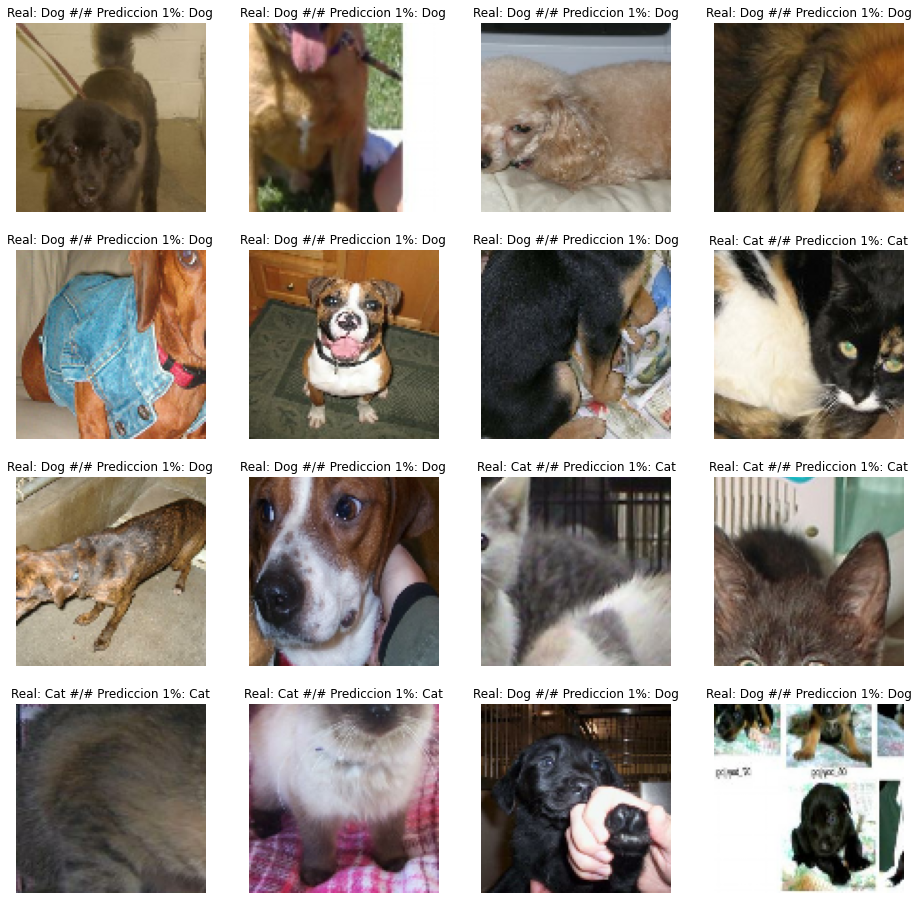

In [9]:
class_names = ['Cat', 'Dog']
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[i])
    label = class_names[labels[i]]
    predicted = class_names[pred[i]]
    plt.title('Real: ' + label + ' #/# Prediccion 1%: ' + predicted)
    plt.axis("off")
plt.savefig('100pcttransfer_learning.jpg')

In [10]:
df = pd.DataFrame(list(zip(epochs, hist_loss, hist_acc)), columns =['Epoch', 'Loss', 'Accuracy'])
df.to_csv('transfer100pct50epochs.csv', index=False)